<a href="https://colab.research.google.com/github/ssttv/ml-resources/blob/master/gradient_descent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt-get install -y -qq software-properties-common module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Selecting previously unselected package libkmod2:amd64.
(Reading database ... 26397 files and directories currently installed.)
Preparing to unpack .../libkmod2_24-1ubuntu3.1_amd64.deb ...
Unpacking libkmod2:amd64 (24-1ubuntu3.1) ...
Selecting previously unselected package kmod.
Preparing to unpack .../kmod_24-1ubuntu3.1_amd64.deb ...
Unpacking kmod (24-1ubuntu3.1) ...
Selecting previously unselected package module-init-tools.
Preparing to unpack .../module-init-tools_24-1ubuntu3.1_all.deb ...
Unpacking module-init-tools (24-1ubuntu3.1) ...
Setting up libkmod2:amd64 (24-1ubuntu3.1) ...
Processing triggers for libc-bin (2.27-3ubuntu1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Setting up kmod (24-1ubuntu3.1) ...
Setting up module-init-tools (24-1ubuntu3.1) ...
Selecting previously unselected package libfuse2:amd64.
(Reading database ... 26444 files and directories currently installed.)
Preparing to unpack .../libfuse2_2.9.7-1ubuntu1_amd64.deb ...
Unpacking libfuse2:amd64 

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
import warnings
warnings.filterwarnings('ignore')
import os
import re
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
from sklearn.datasets import fetch_20newsgroups, load_files
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, log_loss
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [0]:
data_demo = pd.read_csv('/content/drive/generic_datasets/heights_weights.csv')

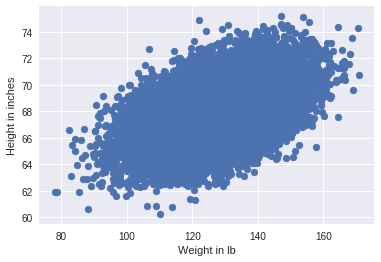

In [8]:
plt.scatter(data_demo['Weight'], data_demo['Height']);
plt.xlabel('Weight in lb')
plt.ylabel('Height in inches');

In [13]:
df = pd.read_csv('/content/drive/generic_datasets/bank_train.csv')
labels = pd.read_csv('/content/drive/generic_datasets/bank_train_target.csv',
                     header=None)
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,26,student,single,high.school,no,no,no,telephone,jun,mon,901,1,999,0,nonexistent,1.4,94.465,-41.8,4.961,5228.1
1,46,admin.,married,university.degree,no,yes,no,cellular,aug,tue,208,2,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1
2,49,blue-collar,married,basic.4y,unknown,yes,yes,telephone,jun,tue,131,5,999,0,nonexistent,1.4,94.465,-41.8,4.864,5228.1
3,31,technician,married,university.degree,no,no,no,cellular,jul,tue,404,1,999,0,nonexistent,-2.9,92.469,-33.6,1.044,5076.2
4,42,housemaid,married,university.degree,no,yes,no,telephone,nov,mon,85,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8


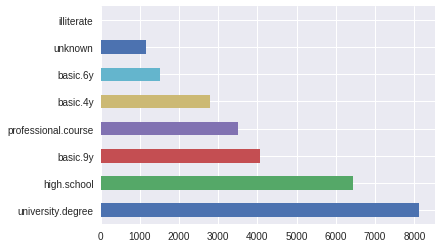

In [16]:
df['education'].value_counts().plot.barh();


In [0]:
label_encoder = LabelEncoder()


{0: 'basic.4y', 1: 'basic.6y', 2: 'basic.9y', 3: 'high.school', 4: 'illiterate', 5: 'professional.course', 6: 'university.degree', 7: 'unknown'}


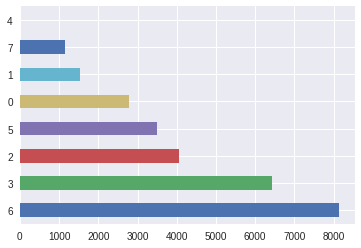

In [18]:
mapped_education = pd.Series(label_encoder.fit_transform(
    df['education']))
mapped_education.value_counts().plot.barh()
print(dict(enumerate(label_encoder.classes_)))

In [19]:
df['education'] = mapped_education
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,26,student,single,3,no,no,no,telephone,jun,mon,901,1,999,0,nonexistent,1.4,94.465,-41.8,4.961,5228.1
1,46,admin.,married,6,no,yes,no,cellular,aug,tue,208,2,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1
2,49,blue-collar,married,0,unknown,yes,yes,telephone,jun,tue,131,5,999,0,nonexistent,1.4,94.465,-41.8,4.864,5228.1
3,31,technician,married,6,no,no,no,cellular,jul,tue,404,1,999,0,nonexistent,-2.9,92.469,-33.6,1.044,5076.2
4,42,housemaid,married,6,no,yes,no,telephone,nov,mon,85,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8


In [20]:
categorical_columns = df.columns[df.dtypes 
                                 == 'object'].union(['education'])
for column in categorical_columns:
    df[column] = label_encoder.fit_transform(df[column])
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,26,8,2,3,0,0,0,1,4,1,901,1,999,0,1,1.4,94.465,-41.8,4.961,5228.1
1,46,0,1,6,0,2,0,0,1,3,208,2,999,0,1,1.4,93.444,-36.1,4.963,5228.1
2,49,1,1,0,1,2,2,1,4,3,131,5,999,0,1,1.4,94.465,-41.8,4.864,5228.1
3,31,9,1,6,0,0,0,0,3,3,404,1,999,0,1,-2.9,92.469,-33.6,1.044,5076.2
4,42,3,1,6,0,2,0,1,7,1,85,1,999,0,1,-0.1,93.200,-42.0,4.191,5195.8


In [0]:
def logistic_regression_accuracy_on(dataframe, labels):
    features = dataframe.as_matrix()
    train_features, test_features, train_labels, test_labels = \
        train_test_split(features, labels)

    logit = LogisticRegression()
    logit.fit(train_features, train_labels)
    return classification_report(test_labels, 
                                 logit.predict(test_features))

In [22]:
one_hot_example = pd.DataFrame([{i: 0 for i in range(10)}])
one_hot_example.loc[0, 6] = 1
one_hot_example

,0,1,2,3,4,5,6,7,8,9
0,0,0,0,0,0,0,1,0,0,0


In [0]:
onehot_encoder = OneHotEncoder(sparse=False)


In [24]:
encoded_categorical_columns = \
pd.DataFrame(onehot_encoder.fit_transform(
    df[categorical_columns]))
encoded_categorical_columns.head()

,0,1,2,3,4,5,6,7,8,9,...,43,44,45,46,47,48,49,50,51,52
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [25]:
print(logistic_regression_accuracy_on(encoded_categorical_columns, labels))

             precision    recall  f1-score   support

          0       0.90      0.99      0.94      6113
          1       0.66      0.17      0.27       786

avg / total       0.87      0.90      0.87      6899



In [26]:
for s in ('university.degree', 'high.school', 'illiterate'):
    print(s, '->', hash(s))

university.degree -> -1927118590565938195
high.school -> -7491272089868468620
illiterate -> -7282440118997650568


In [27]:
hash_space = 25
for s in ('university.degree', 'high.school', 'illiterate'):
    print(s, '->', hash(s) % hash_space)

university.degree -> 5
high.school -> 5
illiterate -> 7


In [28]:
hashing_example = pd.DataFrame([{i: 0.0 for i in range(hash_space)}])
for s in ('job=student', 'marital=single', 'day_of_week=mon'):
    print(s, '->', hash(s) % hash_space)
    hashing_example.loc[0, hash(s) % hash_space] = 1
hashing_example

job=student -> 19
marital=single -> 17
day_of_week=mon -> 19


,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
